In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau #当评价指标不在提升时，减少学习率

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST/',one_hot = False)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [14]:
tri = mnist.train.images
trl = mnist.train.labels
vai = mnist.validation.images
val = mnist.validation.labels

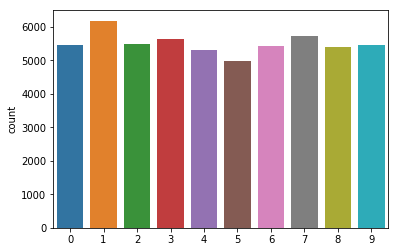

In [15]:
df = pd.Series(trl.reshape(-1,))
sns.countplot(df)

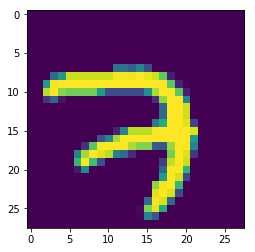

In [27]:
X_tr = tri.reshape(-1,28,28,1)
Y_tr = to_categorical(trl, num_classes=10)
X_va = vai.reshape(-1,28,28,1)
Y_va = to_categorical(val, num_classes=10)
seed = 2
plt.imshow(X_tr[0][:,:,0])


### Model setting

In [33]:
# CNN structure
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size= (4,4), padding='Same',
                activation = 'tanh', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size= (4,4), padding='Same',
                activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size= (5,5), padding='Same',
                activation = 'tanh', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size= (5,5), padding='Same',
                activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'linear'))
model.add(Dropout(0.6))
model.add(Dense(10, activation='softmax'))

# optimizer
opt = RMSprop(lr = 0.001, rho = 0.9, epsilon=1e-8, decay=0.0)

# compile
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# lr annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1,
                                           factor = 0.5, min_lr = 0.00001)

# hyper param
epochs = 5
batch_size = 200

# train
history = model.fit(X_tr, Y_tr, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_va, Y_va), verbose = 2, callbacks = [learning_rate_reduction])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
 - 112s - loss: 0.4000 - acc: 0.8764 - val_loss: 0.0639 - val_acc: 0.9822
Epoch 2/5
 - 111s - loss: 0.1105 - acc: 0.9682 - val_loss: 0.0530 - val_acc: 0.9826
Epoch 3/5
 - 111s - loss: 0.0817 - acc: 0.9778 - val_loss: 0.0371 - val_acc: 0.9892
Epoch 4/5
 - 111s - loss: 0.0720 - acc: 0.9807 - val_loss: 0.0447 - val_acc: 0.9886
Epoch 5/5
 - 111s - loss: 0.0650 - acc: 0.9829 - val_loss: 0.0491 - val_acc: 0.9864


### Evaluation

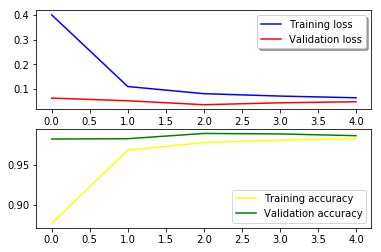

In [36]:
fig, ax = plt.subplots(2,1)
plt.rcParams['figure.figsize'] = (14,10)
ax[0].plot(history.history['loss'], color = 'b', label = 'Training loss')
ax[0].plot(history.history['val_loss'], color = 'r', label = 'Validation loss')
legend = ax[0].legend(loc='best',shadow=True)

ax[1].plot(history.history['acc'], color='yellow', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color='green', label='Validation accuracy')
legend = ax[1].legend(loc='best', shadow = False)

In [40]:
# confusion matrix

Y_pred = model.predict(X_va)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_va, axis=1)
cm = confusion_matrix(Y_true, Y_pred_classes)

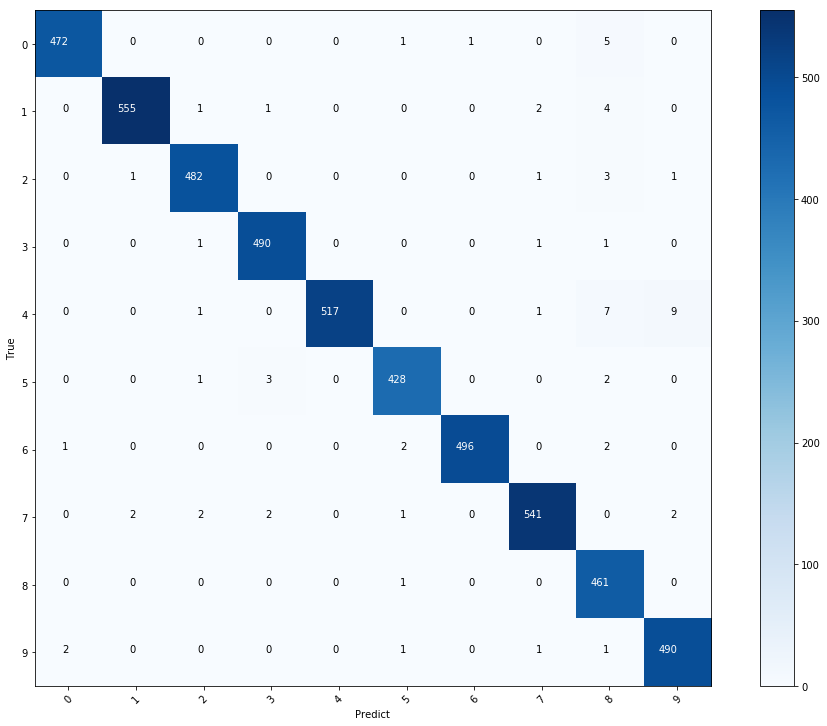

In [58]:
def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, rotation = 45)
    plt.yticks(tick_marks)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='right',
                color = 'white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predict')

plot_confusion_matrix(cm, classes=range(10))

range